In [1]:
# Similarity analysis using embeddings
# Load libraries needed
import torch
from transformers import AutoModel, AutoTokenizer, pipeline
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
# Load the Manifesto model and tokenizer
model_name = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1"
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Check if GPU is available and move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# Load dataset with manifesto party text all combined
df= pd.read_pickle("./data/df_main_sentiment_1999-2019.pkl")
df.head(-1)

,party,date,text,cmp_code,eu_code,sentiment,score,party_name,main_topic,year
0,43110,1999-10-01,For a sustainable Switzerland,NaN,NaN,POSITIVE,0.998674,GPS,other,1999
1,43110,1999-10-01,Election platform 1999,NaN,NaN,POSITIVE,0.987673,GPS,other,1999
2,43110,1999-10-01,The Greens are pleased to present an election ...,501,NaN,POSITIVE,0.998852,GPS,welfare and quality of life,1999
3,43110,1999-10-01,- to briefly present a sustainable Switzerland.,601,NaN,POSITIVE,0.998062,GPS,fabric of society,1999
4,43110,1999-10-01,"In responsibility towards future generations, ...",201,NaN,POSITIVE,0.998758,GPS,freedom and democracy,1999
...,...,...,...,...,...,...,...,...,...,...
18168,43811,2019-10-01,It increases competitiveness as well as planni...,401,NaN,POSITIVE,0.998894,BDP,economy,2019
18169,43811,2019-10-01,The same is true for other projects that lead ...,414,NaN,POSITIVE,0.998668,BDP,economy,2019
18170,43811,2019-10-01,"Various reforms in the financial center, for e...",414,NaN,POSITIVE,0.998879,BDP,economy,2019
18171,43811,2019-10-01,They must be seen as an opportunity.,414,NaN,POSITIVE,0.994448,BDP,economy,2019


In [12]:
# Feature extraction pipeline with batch processing
def extract_embeddings_batch(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)

        # Move tensors to the GPU if available
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states

        # Extract CLS token embeddings for all texts in the batch
        cls_embeddings_batch = hidden_states[-1][:, 0, :].cpu().numpy() 
        all_embeddings.append(cls_embeddings_batch)

    
    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings

In [6]:
# Focus on manifestos from SVP and SPS
svp_sps = ["SVP", "SPS"]
#Focus on manifestos 1999, 2011, and 2019 of SVP and SPS
date_2019 = "2019-10-01"
df_svp_sps_2019 =  df[(df["party_name"].isin(svp_sps)) & (df['date'] == date_2019)]

date_2011 = "2011-10-01"
df_svp_sps_2011 =  df[(df["party_name"].isin(svp_sps)) & (df['date'] == date_2011)]

date_1999 = "1999-10-01"
df_svp_sps_1999 =  df[(df["party_name"].isin(svp_sps)) & (df['date'] == date_1999)]

In [7]:
# Sample data: texts from different party manifestos
texts_2019 = df_svp_sps_2019['text'].tolist()
party_names_2019 = df_svp_sps_2019['party_name'].tolist()

texts_2011 = df_svp_sps_2011['text'].tolist()
party_names_2011 = df_svp_sps_2011['party_name'].tolist()

texts_1999 = df_svp_sps_1999['text'].tolist()
party_names_1999 = df_svp_sps_1999['party_name'].tolist()

In [8]:
# Check that the texts have been correctly extracted
assert len(texts_2019) == len(party_names_2019)
assert len(texts_2011) == len(party_names_2011)
assert len(texts_1999) == len(party_names_1999)

In [13]:
# Process the texts and create embeddings
all_embeddings_2019 = extract_embeddings_batch(texts_2019)
all_embeddings_2011 = extract_embeddings_batch(texts_2011)
all_embeddings_1999 = extract_embeddings_batch(texts_1999)

print(all_embeddings_2019.shape)
print(all_embeddings_2011.shape)
print(all_embeddings_1999.shape)

100%|██████████| 98/98 [00:12<00:00,  8.00it/s]

(1851, 1024)
(218, 1024)
(1564, 1024)


In [14]:
# Calculate cosine similarity matrix
similarity_matrix_2019 = cosine_similarity(all_embeddings_2019)
distance_matrix_2019 = 1 - similarity_matrix_2019

similarity_matrix_2011 = cosine_similarity(all_embeddings_2011)
distance_matrix_2011 = 1 - similarity_matrix_2011

similarity_matrix_1999 = cosine_similarity(all_embeddings_1999)
distance_matrix_1999 = 1 - similarity_matrix_1999

# Cosine Similarity Matrix for all 3 years
print("Cosine Similarity Matrix:")
print(similarity_matrix_2019)
print(similarity_matrix_2011)
print(similarity_matrix_1999)

Cosine Similarity Matrix:
[[0.9999997  0.355166   0.4358068  ... 0.34901634 0.45180425 0.41362894]
 [0.355166   1.0000002  0.65414906 ... 0.26531798 0.34381798 0.22940135]
 [0.4358068  0.65414906 0.9999999  ... 0.29552445 0.34908268 0.24333376]
 ...
 [0.34901634 0.26531798 0.29552445 ... 0.9999997  0.47732255 0.58829784]
 [0.45180425 0.34381798 0.34908268 ... 0.47732255 1.0000002  0.6729447 ]
 [0.41362894 0.22940135 0.24333376 ... 0.58829784 0.6729447  1.0000001 ]]
[[ 1.          0.4688034   0.7216428  ... -0.01478779  0.45901072
   0.07653725]
 [ 0.4688034   1.0000004   0.41412145 ...  0.23140615  0.31509057
   0.24384302]
 [ 0.7216428   0.41412145  1.0000004  ...  0.10553549  0.3971756
   0.16720629]
 ...
 [-0.01478779  0.23140615  0.10553549 ...  0.9999999   0.53928447
   0.8120483 ]
 [ 0.45901072  0.31509057  0.3971756  ...  0.53928447  0.99999964
   0.5633658 ]
 [ 0.07653725  0.24384302  0.16720629 ...  0.8120483   0.5633658
   0.99999994]]
[[ 1.0000002   0.2667498   0.13658448 ..

In [16]:
# Average pair-wise distances within and between parties 2019
party_A_indices_2019 = [i for i, name in enumerate(party_names_2019) if name == "SVP"]
party_B_indices_2019 = [i for i, name in enumerate(party_names_2019) if name == "SPS"]
len_a_2019 = len(party_A_indices_2019)
len_b_2019 = len(party_B_indices_2019)

within_party_a_distance_2019= np.mean(distance_matrix_2019[np.ix_(party_A_indices_2019, party_A_indices_2019)])
within_party_b_distance_2019 = np.mean(distance_matrix_2019[np.ix_(party_B_indices_2019, party_B_indices_2019)])
between_parties_distance_2019 = np.mean(distance_matrix_2019[np.ix_(party_A_indices_2019, party_B_indices_2019)])

# Print distances for 2019
print(f"Within Party SVP Distance 2019: {within_party_a_distance_2019}")
print(f"Within Party SPS Distance 2019: {within_party_b_distance_2019}")
print(f"Between Parties Distance 2019: {between_parties_distance_2019}")

# Average pair-wise distances within and between parties 2011
party_A_indices_2011 = [i for i, name in enumerate(party_names_2011) if name == "SVP"]
party_B_indices_2011 = [i for i, name in enumerate(party_names_2011) if name == "SPS"]

len_a_2011 = len(party_A_indices_2011)
len_b_2011 = len(party_B_indices_2011)

within_party_a_distance_2011 = np.mean(distance_matrix_2011[np.ix_(party_A_indices_2011, party_A_indices_2011)])
within_party_b_distance_2011 = np.mean(distance_matrix_2011[np.ix_(party_B_indices_2011, party_B_indices_2011)])
between_parties_distance_2011 = np.mean(distance_matrix_2011[np.ix_(party_A_indices_2011, party_B_indices_2011)])

# Print distances for 2011
print(f"Within Party SVP Distance 2011: {within_party_a_distance_2011}")
print(f"Within Party SPS Distance 2011: {within_party_b_distance_2011}")
print(f"Between Parties Distance 2011: {between_parties_distance_2011}")

# Average pair-wise distances within and between parties 1999
party_A_indices_1999 = [i for i, name in enumerate(party_names_1999) if name == "SVP"]
party_B_indices_1999 = [i for i, name in enumerate(party_names_1999) if name == "SPS"]

within_party_a_distance_1999 = np.mean(distance_matrix_1999[np.ix_(party_A_indices_1999, party_A_indices_1999)])
within_party_b_distance_1999 = np.mean(distance_matrix_1999[np.ix_(party_B_indices_1999, party_B_indices_1999)])
between_parties_distance_1999 = np.mean(distance_matrix_1999[np.ix_(party_A_indices_1999, party_B_indices_1999)])

# Print distances for 1999
print(f"Within Party SVP Distance 1999: {within_party_a_distance_1999}")
print(f"Within Party SPS Distance 1999: {within_party_b_distance_1999}")
print(f"Between Parties Distance 1999: {between_parties_distance_1999}")



Within Party SVP Distance 2019: 0.8293689489364624
Within Party SPS Distance 2019: 0.7715081572532654
Between Parties Distance 2019: 0.8602588772773743
Within Party SVP Distance 2011: 0.7160723209381104
Within Party SPS Distance 2011: 0.7545152306556702
Between Parties Distance 2011: 0.9160860776901245
Within Party SVP Distance 1999: 0.8271675109863281
Within Party SPS Distance 1999: 0.8472402691841125
Between Parties Distance 1999: 0.8566543459892273


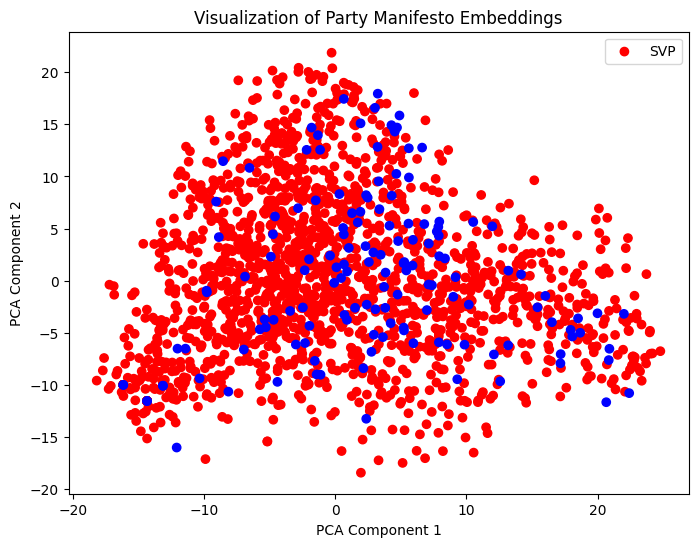

In [18]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings_2019)

# Define party colors
party_colors = ['red'] * len_a_2019 + ['blue'] * len_b_2019

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=party_colors)
plt.title('Visualization of Party Manifesto Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(['SVP','SPS'])
plt.show()

In [ ]:
# Display explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PCA Component 1: {explained_variance[0]:.2f}")
print(f"Explained Variance by PCA Component 2: {explained_variance[1]:.2f}")